# Tweets Language Classification

## Author: Luis Eduardo Ferro Diez <a href="mailto:luis.ferro1@correo.icesi.edu.co">luis.ferro1@correo.icesi.edu.co</a>

This notebook contains the model training preparation for classifying the tweets language.

## Dataset
* Tweets dataset in parquet format (After executing the first transformation spark pipeline)

## Resources
* https://machinelearningmastery.com/best-practices-document-classification-deep-learning/

## Objective
A large number of tweets lack of language identification which is needed in later stages of the project when trying to classify tweets as spam or ham, and furthemore, for simplicity the intention is only to consider english tweets for the analysis of where to sell products geographically speaking.

Depending on the tweet year collection, an important number of tweets does not have language tag, or Twitter itself was not able to identify the language and tagged the `lang` value as `und` for `undefined`. The objective in this notebook is to model two deep learning pipelines with keras to classify if a tweet is either written in english or not. We are not interested for now in the other languages hence we can deem this as a binary classification problem.

### Prepare the data

In [1]:
base_path = "/media/ohtar10/Adder-Storage/datasets/twitter"
tweets_path = base_path + "/pruned/tweets/"

In [2]:
import pandas as pd

tweets = pd.read_parquet(tweets_path, engine="pyarrow")
tweets.head()

,id,tweet,lang,favorite_count,retweet_count,is_retweet,user_id,user_name,user_followers_count,user_following_count,...,place_name,place_full_name,country,country_code,place_type,place_url,year,month,day,hour
0,384905527706542080,I'm at Mahatma Gading Nasional Plus School (Ja...,id,0.0,0.0,0.0,234670148,richardgbt,306.0,280.0,...,Pulo Gadung,"Pulo Gadung, Jakarta Timur",Indonesia,ID,city,https://api.twitter.com/1.1/geo/id/8496c55fb5d...,2013,10,1,0
1,384905536107319296,"But I honestly don't give a fuck, because I di...",en,0.0,0.0,0.0,28929946,rachelzerber,344.0,124.0,...,Arizona,"Arizona, US",United States,US,admin,https://api.twitter.com/1.1/geo/id/a612c69b44b...,2013,10,1,0
2,384905548690653184,Metcalfe / Sainte-Catherine: 01:00 - Disponibl...,de,0.0,0.0,0.0,162780830,BixTweet057,3.0,0.0,...,Montréal,"Montréal, Québec",Canada,CA,city,https://api.twitter.com/1.1/geo/id/378a442883b...,2013,10,1,0
3,384905548690255872,Ask te odio pero a la ves te amo :),es,0.0,0.0,0.0,38001073,bernageek,728.0,469.0,...,Pachuca de Soto,"Pachuca de Soto, Hidalgo",México,MX,city,https://api.twitter.com/1.1/geo/id/8747ffc9cc7...,2013,10,1,0
4,384905552855592961,"""@ThelIluminati: The #governmentshutdown but t...",en,0.0,0.0,0.0,297722693,wifi_whor3,372.0,708.0,...,Pasadena,"Pasadena, TX",United States,US,city,https://api.twitter.com/1.1/geo/id/3e82edc94d5...,2013,10,1,0


We consider the most relevant parts to predict the tweet language to be:
* The tweet text
* The country code

The tweet text might contain user mentions, for simplicity, we will first transform the text, replacing the user mention with the text "@usermention".

Since we are only interested in detecting if a tweet is written in english or not, we would need to transform the `lang` column into a numberic value with `lang=1` for the possitive class, i.e., "The tweet is in english" and `lang=0` for the negative class, i.e., "The tweet is not written in english language."

#### Note
The purpose of this is to train a model to predict the language of the undifined ones, so we need to remove this group from the training set.

In [3]:
tweets.lang.unique()

array(['id', 'en', 'de', 'es', 'fr', 'ru', 'lt', 'tr', 'ja', 'tl', 'nl',
       'da', 'pt', 'und', 'sv', 'sl', 'th', 'vi', 'ht', 'et', 'lv', 'it',
       'zh', 'hu', 'is', 'sk', 'ar', 'no', 'pl', 'fi', 'uk', 'el', 'bg',
       'ko', 'fa', 'he', 'ne', 'ur', 'lo', 'hi', 'iu', 'ka', 'hy', 'ta',
       'km', 'bo', 'pa', 'gu', 'si', 'kn'], dtype=object)

In [4]:
import re

# Keep the undifined language tweets separated
und_tweets = tweets[tweets.lang == 'und']
tweets = tweets[tweets.lang != 'und']

tweets.tweet = tweets.tweet.apply(lambda x: re.sub(r"@[\w\d]+", "@usermention", x))
tweets = tweets[["tweet", "country_code", "lang"]]
tweets.lang = tweets.lang.apply(lambda x: 1.0 if x == 'en' else 0.0)
tweets.head()

,tweet,country_code,lang
0,I'm at Mahatma Gading Nasional Plus School (Ja...,ID,0.0
1,"But I honestly don't give a fuck, because I di...",US,1.0
2,Metcalfe / Sainte-Catherine: 01:00 - Disponibl...,CA,0.0
3,Ask te odio pero a la ves te amo :),MX,0.0
4,"""@usermention: The #governmentshutdown but the...",US,1.0


In [5]:
und_lang_tweets = und_tweets.tweet.count()
dataset_tweets = tweets.tweet.count()
print(f"Amount of tweets with undefined language: {und_lang_tweets}")
print(f"Amount of tweets for training language: {dataset_tweets}")

Amount of tweets with undefined language: 57510
Amount of tweets for training language: 2005888


Now let's convert the country code into a onehot encoding

In [6]:
tweets.country_code.unique()

array(['ID', 'US', 'CA', 'MX', 'FR', 'RU', 'ES', 'LT', 'MY', 'CL', 'GB',
       'TR', 'JP', 'ZA', 'BR', 'NL', 'SE', 'RS', 'DE', 'UA', 'NO', 'BE',
       'IT', 'HU', 'CH', 'DK', 'EE', 'PH', 'LV', 'AR', 'SG', 'DO', 'SA',
       'PL', '', 'CU', 'BY', 'GR', 'IE', 'FI', 'CO', 'MA', 'KR', 'PT',
       'CN', 'AT', 'TH', 'XK', 'BS', 'RO', 'HR', 'CI', 'JM', 'UY', 'AU',
       'MZ', 'MK', 'TN', 'AM', 'LU', 'BB', 'ME', 'PE', 'MN', 'CZ', 'NI',
       'IQ', 'VE', 'GE', 'PY', 'AZ', 'SK', 'EG', 'MQ', 'IL', 'SV', 'QA',
       'GP', 'BF', 'MG', 'DZ', 'YE', 'CY', 'IN', 'EC', 'SM', 'NZ', 'GI',
       'GL', 'PF', 'HK', 'GT', 'HN', 'SY', 'BW', 'BO', 'KP', 'AD', 'LK',
       'SD', 'GH', 'AQ', 'PK', 'ZW', 'SN', 'BN', 'LB', 'JO', 'VG', 'MD',
       'PR', 'HT', 'BG', 'PG', 'PA', 'KM', 'TW', 'VA', 'VN', 'RE', 'CR',
       'KZ', 'AE', 'BA', 'SL', 'MT', 'NC', 'NG', 'LI', 'IR', 'KE', 'SI',
       'AS', 'MV', 'BM', 'DM', 'KY', 'ZM', 'MM', 'KW', 'TM', 'IS', 'CG',
       'FJ', 'TD', 'LR', 'CW', 'TT', 'OM', 'GU', 'TC'

In [7]:
from sklearn.preprocessing import LabelEncoder

country_encoder = LabelEncoder()
country_encoded = country_encoder.fit_transform(tweets.country_code.values).reshape(-1, 1)
tweets['country_encoded'] = country_encoded
tweets.head(10)

,tweet,country_code,lang,country_encoded
0,I'm at Mahatma Gading Nasional Plus School (Ja...,ID,0.0,74
1,"But I honestly don't give a fuck, because I di...",US,1.0,173
2,Metcalfe / Sainte-Catherine: 01:00 - Disponibl...,CA,0.0,29
3,Ask te odio pero a la ves te amo :),MX,0.0,118
4,"""@usermention: The #governmentshutdown but the...",US,1.0,173
5,Magic mike on TV? I think yes,US,1.0,173
6,@usermention Yes! Thank you!,US,1.0,173
7,@usermention don't forget about meeeee,US,1.0,173
8,Trop la flemme d'y aller #on,FR,0.0,57
9,I'm at ВАВТ Минэкономразвития РФ (Всероссийска...,RU,0.0,146


In [8]:
c = tweets.country_code.values
c_encoded = tweets.country_encoded.values
countries = set(zip(c, c_encoded))
list(countries)[:10]

[('GP', 63),
 ('PH', 135),
 ('SE', 150),
 ('AZ', 13),
 ('IN', 77),
 ('JM', 82),
 ('FR', 57),
 ('KY', 92),
 ('TM', 166),
 ('SL', 155)]

## Baseline

In order to assess if the models are good or not, we'll need to establish a baseline. Since this is a classification problem, and there is no previous reference, our baseline is the most predominant class.

In [9]:
tweets.lang.value_counts()

0.0    1201515
1.0     804373
Name: lang, dtype: int64

We can see the majority of tweets are NOT written in english language. Now let's define the baseline

In [10]:
en = tweets.lang.value_counts()[0]
total = tweets.lang.count()
baseline = en / total
print(f"The baseline is: {baseline:.2f}")

The baseline is: 0.60


With "not english" as the predominat class, we have a prediction power of $60\%$. This is what we will try to improve with the models.

With this information we'll create embeddings to train a CNN + Fully Connected ANN to predict the language.

Also for testing, we are going to use a LTSM + Fully Connected ANN and compare the results.

Since we are dealing with two types of features, we'll need to prepare a bidirectional NN

## Tweet Embeddings

First, we'll need to create the embedding representation of the tweet corpus. There are a couple of caveats we must consider:
* A tweet might contain urls, this makes necessary to parse or mask them so they get not separated when tokenizing the text.

In [11]:
from urlextract import URLExtract

def replace_url(string, replacement='', url_extract=URLExtract()):
    urls = url_extract.find_urls(string)
    for url in urls:
        string = string.replace(url, replacement)
    return string

test = "This is a simulated tweet with a url at https://somedomain.com, plus another one at http://www.google.com"
print(f"Replacing with default value: {replace_url(test)}")
print(f"Replacing with cusom value: {replace_url(test, 'some_url')}")

Replacing with default value: This is a simulated tweet with a url at , plus another one at 
Replacing with cusom value: This is a simulated tweet with a url at some_url, plus another one at some_url


In [12]:
%%time
import swifter

url_extract = URLExtract()
tweets.tweet = tweets.tweet.swifter.apply(lambda t: replace_url(t, "sharedurl", url_extract))


CPU times: user 23.9 s, sys: 0 ns, total: 23.9 s
Wall time: 23.8 s


In [13]:
tweets.head()

,tweet,country_code,lang,country_encoded
0,I'm at Mahatma Gading Nasional Plus School (Ja...,ID,0.0,74
1,"But I honestly don't give a fuck, because I di...",US,1.0,173
2,Metcalfe / Sainte-Catherine: 01:00 - Disponibl...,CA,0.0,29
3,Ask te odio pero a la ves te amo :),MX,0.0,118
4,"""@usermention: The #governmentshutdown but the...",US,1.0,173


In [14]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K

s_config = tf.ConfigProto()
#s_config.gpu_options.allow_growth = True
s_config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.keras.backend.set_session(tf.Session(config=s_config))


def show_framework_devices():
    """Just prints the devices the frameworks are using
    at the moment. It will help us to tell if they are indeed
    using GPU's or not"""
    print("Tensorflow registered devices:", device_lib.list_local_devices())
    print("Keras registered GPUs", K.tensorflow_backend._get_available_gpus())

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3

In [15]:
show_framework_devices()

Tensorflow registered devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11180303426745135473
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14589176093161430845
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5022036787
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8413261442655900956
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6201651567652453309
physical_device_desc: "device: XLA_GPU device"
]
Keras registered GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [16]:
import tensorflow.keras.backend as K
from keras.preprocessing.text import Tokenizer

words = 1000
tokenizer = Tokenizer(num_words=words)
tokenizer.fit_on_texts(tweets.tweet)
print(f"Unique tokens: {len(tokenizer.word_index)}")
n = 200
firstn = {k:tokenizer.word_index[k] for k in list(tokenizer.word_index)[:n]}
print(f"The first {n} items in the word index are: {firstn}")

Unique tokens: 1144167
The first 200 items in the word index are: {'usermention': 1, 'sharedurl': 2, 'i': 3, 'a': 4, 'to': 5, 'the': 6, 'at': 7, 'me': 8, 'de': 9, 'you': 10, "i'm": 11, 'my': 12, 'que': 13, 'and': 14, 'in': 15, 'is': 16, 'no': 17, 'for': 18, 'of': 19, 'it': 20, 'on': 21, 'la': 22, 'rt': 23, 'o': 24, 'with': 25, 'so': 26, 'that': 27, '—': 28, 'w': 29, 'this': 30, 'just': 31, 'e': 32, 'do': 33, 'be': 34, 'd': 35, '“': 36, 'like': 37, 'gt': 38, 'y': 39, '3': 40, 'ya': 41, 'en': 42, 'have': 43, 'eu': 44, 'lt': 45, 'others': 46, 'se': 47, 'up': 48, 'love': 49, 'not': 50, 'el': 51, 'but': 52, 'amp': 53, 'haha': 54, 'get': 55, 'your': 56, 'all': 57, 'was': 58, 'lol': 59, 'are': 60, 'p': 61, "don't": 62, 'te': 63, '2': 64, 'what': 65, 'aku': 66, 'é': 67, 'da': 68, 'di': 69, 'u': 70, 'if': 71, 'out': 72, 'we': 73, 'by': 74, 'un': 75, 'when': 76, 'go': 77, 'good': 78, "it's": 79, 'yg': 80, 'pic': 81, 'now': 82, 'não': 83, 'lo': 84, 'one': 85, 'know': 86, 'can': 87, 'mi': 88, 'day

In [17]:
tweets.tweet.values

array(["I'm at Mahatma Gading Nasional Plus School (Jakarta Utara, Jakarta Capital Region) sharedurl",
       "But I honestly don't give a fuck, because I didn't do shit to you lol",
       'Metcalfe / Sainte-Catherine: 01:00 - Disponible: 0, Stationnement: 27',
       ...,
       '#TEAM : Together, Everyone, Achieves, More, *There is no I in TEAM"!!*',
       '@usermention Sí, en ese grupo de WA, que no sé que ha sido de él.',
       '@usermention みんなアラフェス外れたからさ(・ε・｀) オレもその一人。そして願ってるよ。新国立で嵐さんがパフォーマンスしてくれる日を。だから当たり前に話すのはナンセンスだけどちょっとは分かってあげてね？ヽ(*´∀｀)ノ'],
      dtype=object)

In [18]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_TEXT_SEQ_LEN = 280
tweet_sequences = np.array(tokenizer.texts_to_sequences(tweets.tweet))
tweet_sequences = pad_sequences(tweet_sequences, MAX_TEXT_SEQ_LEN)

In [19]:
def print_text_and_sequence(tweets, sequences, n=10):
    for i in range(n):
        print(f"Tweet text: {tweets[i]}")
        print(f"Tweet sequence: {sequences[i]}")
        print("#" * 10)

In [20]:
print_text_and_sequence(tweets.tweet, tweet_sequences)

Tweet text: I'm at Mahatma Gading Nasional Plus School (Jakarta Utara, Jakarta Capital Region) sharedurl
Tweet sequence: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   

`tweet_sequences` contains the indexed text strings which are going to be the input for the NN.

Now, let's assemble everything and prepare the train and test sets.

In [21]:
from sklearn.model_selection import train_test_split

X = tweet_sequences
X_c = country_encoded
y = tweets.lang.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train_c, X_test_c, _, _ = train_test_split(X_c, y, test_size=0.2, random_state=1234)

Now, let's define the models

## LSTM based model

First, we will train a LSTM based model with the embeddings of each tweet, and make predictions for the tweet language.

In [22]:
from keras.layers import Input, Embedding, Bidirectional, Dense, LSTM, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras import regularizers

#Define the inputs
tweet_input = Input(shape=(MAX_TEXT_SEQ_LEN,), dtype='int32', name='tweet_text')
country_input = Input(shape=(1,), name='country_input')

#Define the embedding layer consuming the tweet input
emb = Embedding(input_dim=tokenizer.num_words, output_dim=64, input_length=MAX_TEXT_SEQ_LEN)(tweet_input)

#Define the LSTM layer with the embedding input
tweet_output = Bidirectional(
        LSTM(units=30, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01))
    )(emb)

#Define an auxiliary output for the first input
aux_output = Dense(1, activation='sigmoid', name='aux_output')(tweet_output)

#Concatenate the LSTM output with the country input
x = concatenate([tweet_output, country_input])

#Apply a dense layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(25, activation='relu')(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(1, activation='sigmoid', name='prediction')(x)

model = Model(inputs=[tweet_input, country_input], outputs=[main_output, aux_output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tweet_text (InputLayer)         (None, 280)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 280, 64)      64000       tweet_text[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60)           22800       embedding_1[0][0]                
__________________________________________________________________________________________________
country_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [23]:
X_train.shape

(1604710, 280)

In [24]:
%%time
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_data = [X_train, X_train_c]
history = model.fit(train_data, [y_train] * 2, epochs = 5, batch_size = 1000, validation_split= 0.2, callbacks=[early_stopping])

Train on 1283768 samples, validate on 320942 samples
Epoch 1/5
1283768/1283768 [==============================] - 686s 534us/step - loss: 0.4630 - prediction_loss: 0.1710 - aux_output_loss: 0.2037 - prediction_acc: 0.9326 - aux_output_acc: 0.9193 - val_loss: 0.3139 - val_prediction_loss: 0.1444 - val_aux_output_loss: 0.1618 - val_prediction_acc: 0.9435 - val_aux_output_acc: 0.9377
Epoch 2/5
1283768/1283768 [==============================] - 679s 529us/step - loss: 0.3152 - prediction_loss: 0.1484 - aux_output_loss: 0.1611 - prediction_acc: 0.9422 - aux_output_acc: 0.9391 - val_loss: 0.3466 - val_prediction_loss: 0.1838 - val_aux_output_loss: 0.1587 - val_prediction_acc: 0.9319 - val_aux_output_acc: 0.9393
Epoch 3/5
1283768/1283768 [==============================] - 679s 529us/step - loss: 0.3079 - prediction_loss: 0.1454 - aux_output_loss: 0.1589 - prediction_acc: 0.9430 - aux_output_acc: 0.9399 - val_loss: 0.3031 - val_prediction_loss: 0.1418 - val_aux_output_loss: 0.1579 - val_predic

In [26]:
import matplotlib.pyplot as plt

def plot_history(cnn, acc= 'acc', val_acc = 'val_acc', loss = 'loss', val_loss = 'val_loss'):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'])
    
    plt.show()
    

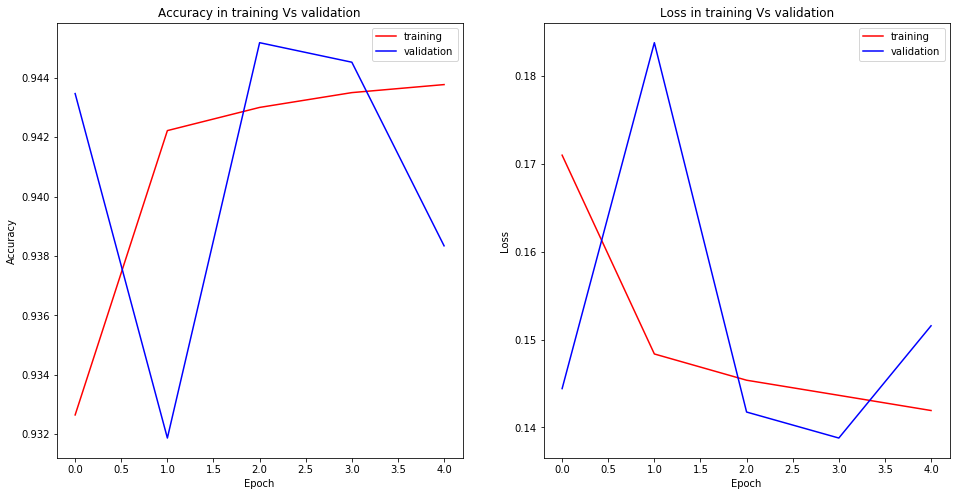

In [26]:
plot_history(history, 
             acc='prediction_acc', 
             val_acc='val_prediction_acc', 
             loss='prediction_loss', 
             val_loss='val_prediction_loss')

In [27]:
test_prediction = model.predict([X_test, X_test_c])
y_pred = np.where(test_prediction[0]>0.5, 1.0, 0.0)

In [28]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.2f}")

Test accuracy: 0.94


In [29]:
model.save("../../models/keras/tweet-lang-classification-lstm.h5")

With this sample and tiny model we got $94\%$ of accuracy score within the testing set which is acceptable considering our initial baseline of $64\%$

## CNN Based model
Now let's design a model using Convolutional Neural Networks with the same embeddings and see how it performs against our LSTM based model.

In [23]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras import regularizers

#Define the inputs
tweet_input = Input(shape=(MAX_TEXT_SEQ_LEN,), dtype='int32', name='tweet_text')
country_input = Input(shape=(1,), name='country_input')

#Define the embedding layer consuming the tweet input
emb = Embedding(input_dim=tokenizer.num_words, 
                output_dim=64, 
                input_length=MAX_TEXT_SEQ_LEN)(tweet_input)

#Define the convolutional layers consuming the tweet input
conv = Conv1D(32, 3, activation='relu', input_shape=(64,))(emb)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='relu')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='relu')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv_output = Flatten()(conv)

#Define an auxiliary output for the first input
aux_output = Dense(1, activation='sigmoid', name='aux_output')(conv_output)

#Concatenate the convolutional output with the country input
x = concatenate([conv_output, country_input])

#Apply a dense layers
x = Dense(50, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(25, activation='relu')(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(1, activation='sigmoid', name='prediction')(x)

model = Model(inputs=[tweet_input, country_input], outputs=[main_output, aux_output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tweet_text (InputLayer)         (None, 280)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 280, 64)      64000       tweet_text[0][0]                 
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 278, 32)      6176        embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 139, 32)      0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (

In [24]:
%%sh
TF_FORCE_GPU_ALLOW_GROWTH=true

In [25]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_data = [X_train, X_train_c]
history = model.fit(train_data, [y_train] * 2, epochs = 5, batch_size = 10, validation_split= 0.2, callbacks=[early_stopping])

Train on 1283768 samples, validate on 320942 samples
Epoch 1/5
1283768/1283768 [==============================] - 638s 497us/step - loss: 0.4882 - prediction_loss: 0.2342 - aux_output_loss: 0.2539 - prediction_acc: 0.9003 - aux_output_acc: 0.8991 - val_loss: 0.4663 - val_prediction_loss: 0.2159 - val_aux_output_loss: 0.2504 - val_prediction_acc: 0.9078 - val_aux_output_acc: 0.8996
Epoch 2/5
1283768/1283768 [==============================] - 621s 484us/step - loss: 0.4724 - prediction_loss: 0.2227 - aux_output_loss: 0.2497 - prediction_acc: 0.9048 - aux_output_acc: 0.9009 - val_loss: 0.4654 - val_prediction_loss: 0.2145 - val_aux_output_loss: 0.2509 - val_prediction_acc: 0.9056 - val_aux_output_acc: 0.8997
Epoch 3/5
1283768/1283768 [==============================] - 590s 459us/step - loss: 0.4670 - prediction_loss: 0.2176 - aux_output_loss: 0.2493 - prediction_acc: 0.9065 - aux_output_acc: 0.9010 - val_loss: 0.4554 - val_prediction_loss: 0.2056 - val_aux_output_loss: 0.2499 - val_predic

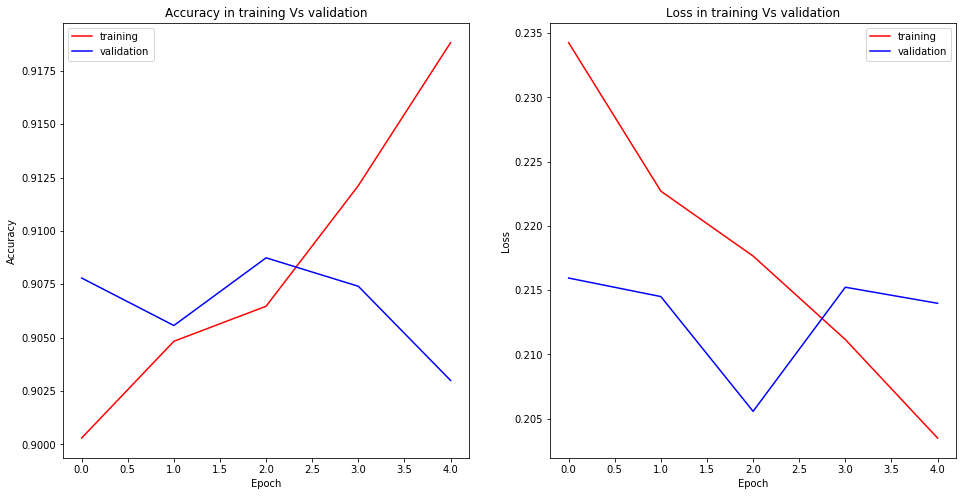

In [27]:
plot_history(history, 
             acc='prediction_acc', 
             val_acc='val_prediction_acc', 
             loss='prediction_loss', 
             val_loss='val_prediction_loss')

In [28]:
test_prediction = model.predict([X_test, X_test_c])
y_pred = np.where(test_prediction[0]>0.5, 1.0, 0.0)

In [29]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.2f}")

Test accuracy: 0.90


It seems that with the convolutional based model we get more accurate and with the additional benefit of a faster training. Hence, We will export the CNN based model for later usage in spark.

In [30]:
model.save("../../models/keras/tweet-lang-classification-cnn.h5")